In [ ]:
pip install torch torchvision torchmetrics torch-fidelity tensorboard tqdm numpy medmnist Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 41.6 MB/s eta 0:00:00
 

In [ ]:
!pip install torchmetrics

In [ ]:
!pip install medmnist

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from medmnist import ChestMNIST
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()

In [ ]:
# Set device
device = torch.device("cpu")

In [ ]:
# Load MedMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
import os

# Ensure the directory exists
os.makedirs("./data", exist_ok=True)

# Now load the dataset
train_dataset = ChestMNIST(root="./data", split="train", download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 82.8M/82.8M [00:07<00:00, 10.4MB/s]


In [ ]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

In [ ]:
# WGAN-GP Gradient Penalty
def gradient_penalty(D, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    d_interpolates = D(interpolates)
    grad_outputs = torch.ones_like(d_interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates, grad_outputs=grad_outputs,
        create_graph=True, retain_graph=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [ ]:
# Training Function
def train_gan(gan_type, num_epochs=10):
    writer = SummaryWriter(f"runs/{gan_type}")

    z_dim = 100
    generator = Generator(z_dim).to(device)
    discriminator = Discriminator().to(device)

    optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for real, _ in tqdm(train_loader):
            real = real.to(device)

            # Generate fake images
            z = torch.randn(real.size(0), z_dim).to(device)
            fake = generator(z)

            # Discriminator update
            optim_D.zero_grad()
            real_loss, fake_loss = 0, 0

            if gan_type == "LS-GAN":
                real_loss = 0.5 * ((discriminator(real) - 1) ** 2).mean()
                fake_loss = 0.5 * (discriminator(fake) ** 2).mean()
            elif gan_type == "WGAN":
                real_loss = -discriminator(real).mean()
                fake_loss = discriminator(fake).mean()
            elif gan_type == "WGAN-GP":
                real_loss = -discriminator(real).mean()
                fake_loss = discriminator(fake).mean()
                gp = gradient_penalty(discriminator, real, fake)
                loss_D = real_loss + fake_loss + 10 * gp
            else:
                raise ValueError("Invalid GAN type")

            loss_D = real_loss + fake_loss
            loss_D.backward()
            optim_D.step()

            # Generator update
            if epoch % 5 == 0:
                optim_G.zero_grad()
                fake = generator(z)
                loss_G = -discriminator(fake).mean() if gan_type in ["WGAN", "WGAN-GP"] else ((discriminator(fake) - 1) ** 2).mean()
                loss_G.backward()
                optim_G.step()

                # TensorBoard Logging
                writer.add_scalar("Loss/Discriminator", loss_D.item(), epoch)
                writer.add_scalar("Loss/Generator", loss_G.item(), epoch)

        # Save generated images
        vutils.save_image(fake[:25], f"generated/{gan_type}_epoch_{epoch}.png", normalize=True)

    torch.save(generator.state_dict(), f"models/{gan_type}_generator.pth")
    writer.close()

In [ ]:
# Ensure directories exist
os.makedirs("generated", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [ ]:
# Train all three GANs
for gan in ["LS-GAN", "WGAN", "WGAN-GP"]:
    train_gan(gan)

100%|██████████| 1227/1227 [00:32<00:00, 37.71it/s]


LS-GAN - FID Score: 387.7719, Inception Score: 1.0000


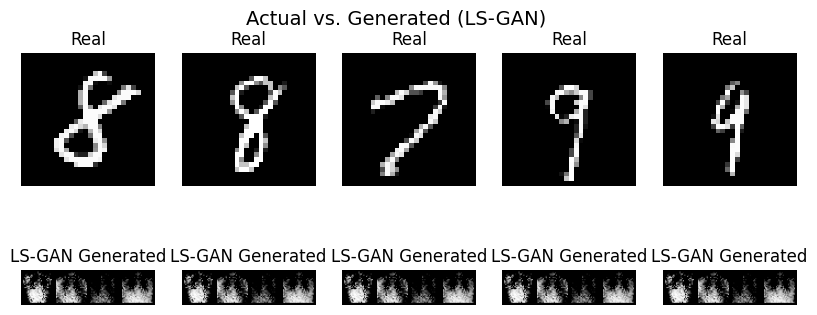

WGAN - FID Score: 334.1937, Inception Score: 1.0000


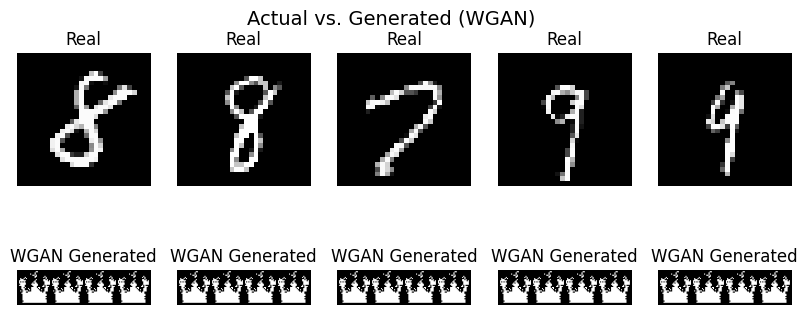

WGAN-GP - FID Score: 332.1943, Inception Score: 1.0000


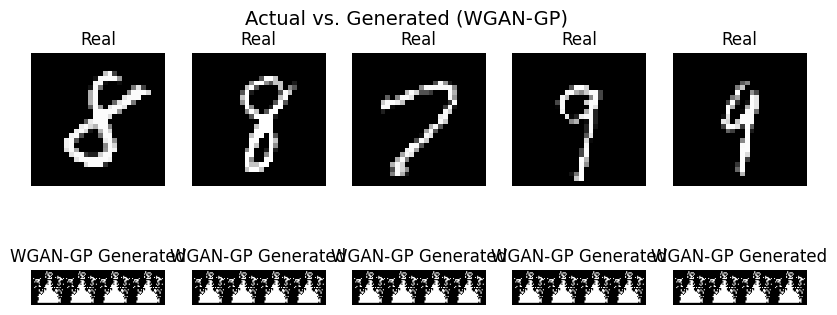

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import os
from PIL import Image

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load real images from MNIST (convert to 3 channels for FID)
def get_real_images(num_images=100):
    dataset = MNIST(root="./data", train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]), download=True)

    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    real_images, _ = next(iter(loader))

    # Convert grayscale (1 channel) to RGB (3 channels)
    real_images = real_images.repeat(1, 3, 1, 1)
    return real_images.to(device)

# Load generated images from saved files (assumed as single PNG per GAN)
def get_generated_images(gan_type, epoch=9, num_images=10):
    img_path = f"generated/{gan_type}_epoch_{epoch}.png"
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        return None

    img = Image.open(img_path).convert("L")  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert to RGB
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    img = transform(img)  # Shape: [3, H, W]
    img = img.unsqueeze(0).repeat(num_images, 1, 1, 1)  # Repeat to match batch size

    return img.to(device)  # Shape: [batch, 3, H, W]

# Compute FID Score
def compute_fid(real_images, generated_images):
    fid = FrechetInceptionDistance(normalize=True).to(device)

    # Convert to uint8 (0-255) since FID expects this format
    real_images = ((real_images * 0.5 + 0.5) * 255).byte()
    generated_images = ((generated_images * 0.5 + 0.5) * 255).byte()

    fid.update(real_images, real=True)
    fid.update(generated_images, real=False)
    return fid.compute().item()

# Compute Inception Score
def compute_inception_score(generated_images):
    inception = InceptionScore().to(device)

    # Convert to uint8 (0-255)
    generated_images = ((generated_images * 0.5 + 0.5) * 255).byte()

    inception.update(generated_images)
    # The compute() returns a tuple, so we index the first element
    return inception.compute()[0].item()

# Compare Actual vs. Generated Images
def plot_images(real_images, generated_images, gan_type):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))

    for i in range(5):
        axes[0, i].imshow(real_images[i].cpu().permute(1, 2, 0))
        axes[0, i].set_title("Real")
        axes[0, i].axis("off")

        axes[1, i].imshow(generated_images[i].cpu().permute(1, 2, 0))
        axes[1, i].set_title(f"{gan_type} Generated")
        axes[1, i].axis("off")

    plt.suptitle(f"Actual vs. Generated ({gan_type})", fontsize=14)
    plt.show()

# Evaluate FID and Inception Score for each GAN
gan_types = ["LS-GAN", "WGAN", "WGAN-GP"]
epoch = 9  # Last epoch

real_images = get_real_images(10)

for gan in gan_types:
    generated_images = get_generated_images(gan, epoch, 10)

    if generated_images is None:
        continue

    fid_score = compute_fid(real_images, generated_images)
    inception_score = compute_inception_score(generated_images)

    print(f"{gan} - FID Score: {fid_score:.4f}, Inception Score: {inception_score:.4f}")

    plot_images(real_images, generated_images, gan)
